In [2]:
import pandas as pd
import seaborn as sns
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.ticker import PercentFormatter

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request
import numpy as np

urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (3.5, 3.5 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

In [4]:
# set up via Google Sheets API
import os
from dotenv import load_dotenv
import gspread

load_dotenv()
sheet_id = os.environ['sheet_id']

gc = gspread.service_account(filename="/Users/quinny/repos/mdagent-key.json")
sheets = gc.open_by_key(sheet_id)

# model performance & step analysis

In [72]:
worksheet = sheets.worksheet("k1 results")

In [89]:
result = worksheet.get("A229:L238")
df = pd.DataFrame(result[2:], columns=result[1]) # ignore first row, trivial
df.set_index(df.columns[0], inplace=True)
df = df.apply(pd.to_numeric)
df = df.iloc[:, 5:] # remove first 5 columns
df.head()

,completed without runtime error,all steps attempted,Completed wo hallucination,Logic makes sense,answer is logical,avg % steps completed
Model,,,,,,
gpt-3.5-turbo,0.880,0.3600,0.6800,0.5200,0.3200,0.5966
gpt-4-1106-preview,0.840,0.4800,0.7600,0.4800,0.3200,0.6177
gpt-4-turbo,0.800,0.4400,0.8400,0.5200,0.4400,0.5847
gpt-4o,0.880,0.9200,1.0000,0.8800,0.7200,0.9234
Claude 3 Opus,0.875,0.6667,0.9167,0.9167,0.6667,0.7966


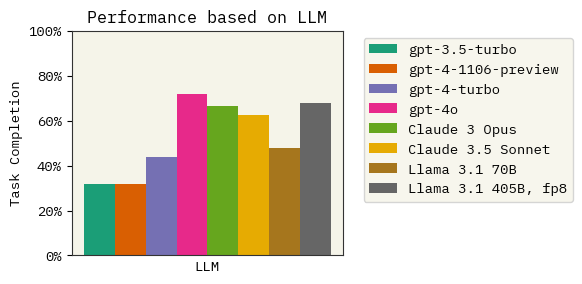

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#plt.bar(df.index, df['answer is logical '], color=colors)
for i, label in enumerate(df.index):
    plt.bar(label, df.loc[label, 'answer is logical '], color=colors[i % len(colors)], label=label, width=1.0)

plt.title('Performance based on LLM')
plt.xlabel('LLM')
plt.xticks([])
plt.ylabel('Task Completion')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('e4-parta_nov42024.png',dpi=300, bbox_inches='tight')

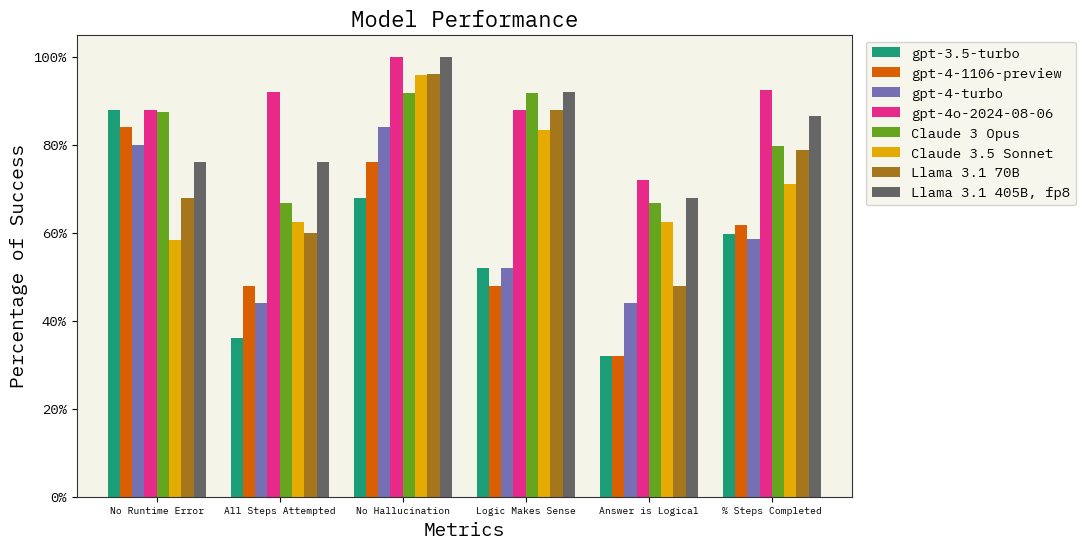

In [76]:
fig, ax = plt.subplots(figsize=(10, 6))

metrics = [
   "No Runtime Error",  "All Steps Attempted",  
     "No Hallucination",  "Logic Makes Sense", "Answer is Logical",
     "% Steps Completed"
]
df_transposed = df.T

ax = df_transposed.plot(kind='bar', width=0.8, ax=ax)
plt.title("Model Performance", size=16)
plt.xlabel('Metrics', size=14)
plt.ylabel('Percentage of Success', size=14)
ax.set_xticklabels(metrics, rotation=0, size=7)
plt.ylim(0, 1.05)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
#plt.legend()

### task completion (logical final answer) vs N steps

In [84]:
# logical final answer vs num. steps

result = worksheet.get("M242:V250")
models = worksheet.get("A231:A238")
models = [m[0] for m in models]
df = pd.DataFrame(result[1:], columns=result[0], index=models)
df = df.apply(pd.to_numeric)
steps2_logical_df = df
steps2_logical_df.head()

,1,2,3,4,5,6,7,8,9,10
gpt-3.5-turbo,1.0,1.0,0.3333,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
gpt-4-1106-preview,1.0,1.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.5,0.0
gpt-4-turbo,1.0,1.0,0.6667,0.3333,0.0,0.0,0.5,0.0,0.0,0.0
gpt-4o,1.0,1.0,1.0000,0.3333,1.0,0.5,0.5,0.5,0.5,0.5
Claude 3 Opus,1.0,1.0,1.0000,0.6667,1.0,0.5,1.0,0.5,1.0,0.0


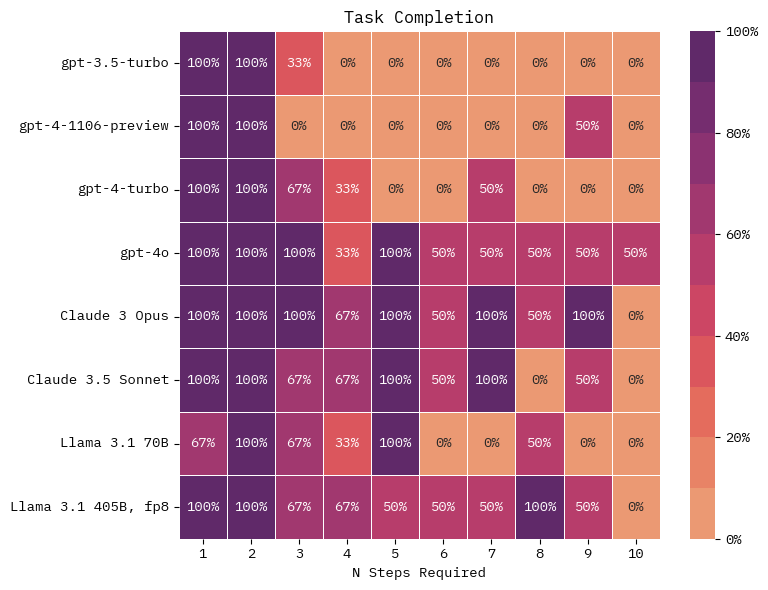

In [85]:
intervals = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
cmap = sns.color_palette("flare", len(intervals) - 1)

plt.figure(figsize=(8, 6))
sns.heatmap(steps2_logical_df, annot=True, cmap=cmap, fmt=".0%", linewidths=0.5)

cbar = plt.gca().collections[0].colorbar
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

# # Set labels and title
plt.xlabel("N Steps Required")
plt.title("Task Completion")

# Show the plot
plt.tight_layout()
plt.savefig('steps-part1.png',dpi=300)
plt.show()

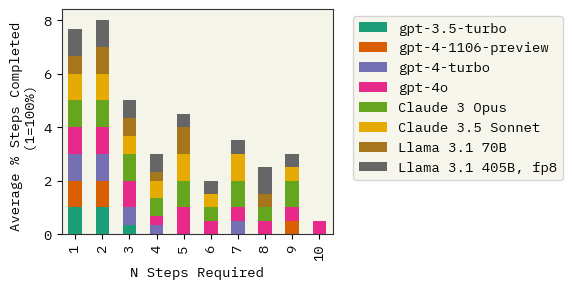

In [86]:
df_transposed = steps2_logical_df.T
ax = df_transposed.plot(kind='bar', stacked=True) #figsize=(10, 6))
plt.legend(bbox_to_anchor=(1.05, 1)) #loc='upper left')
plt.ylabel('Average % Steps Completed \n (1=100%)')
plt.xlabel('N Steps Required')

plt.show()

### steps completed vs N steps

In [87]:
# steps completed vs num. steps
result = worksheet.get("M230:V238")
models = worksheet.get("A231:A238")
models = [m[0] for m in models]
df = pd.DataFrame(result[1:], columns=result[0], index=models)
df = df.apply(pd.to_numeric)
steps1_df = df
steps1_df.head()

,1,2,3,4,5,6,7,8,9,10
gpt-3.5-turbo,1.0000,1.0,0.5556,0.4167,0.5,0.0000,0.4286,0.4375,0.8333,0.30
gpt-4-1106-preview,1.0000,1.0,0.2222,0.6667,0.3,0.4167,0.2143,0.5625,0.9444,0.45
gpt-4-turbo,1.0000,1.0,0.7778,0.5000,0.3,0.5833,0.5714,0.4375,0.0000,0.00
gpt-4o,1.0000,1.0,1.0000,0.8333,1.0,0.8333,0.7143,1.0000,0.9444,0.80
Claude 3 Opus,0.6667,1.0,0.7778,0.9167,1.0,0.8333,0.5000,0.5625,0.7222,0.40


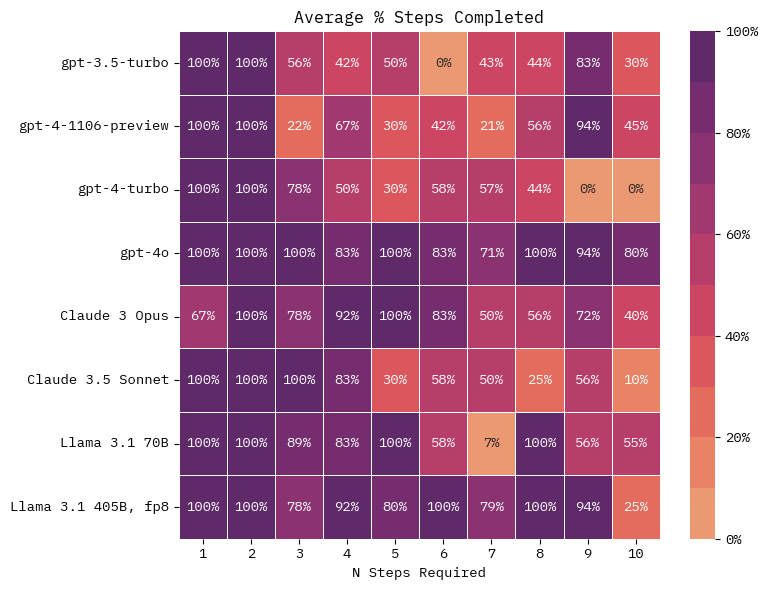

In [88]:
intervals = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
cmap = sns.color_palette("flare", len(intervals) - 1)

plt.figure(figsize=(8, 6))
sns.heatmap(steps1_df, annot=True, cmap=cmap, fmt=".0%", linewidths=0.5)

cbar = plt.gca().collections[0].colorbar
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

# # Set labels and title
plt.xlabel("N Steps Required")
plt.title("Average % Steps Completed")

# Show the plot
plt.tight_layout()
plt.savefig('steps-part2.png',dpi=300)
plt.show()

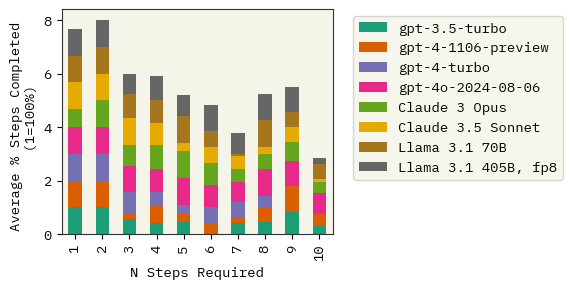

In [110]:
df_transposed = steps1_df.T
ax = df_transposed.plot(kind='bar', stacked=True) #figsize=(10, 6))
plt.legend(bbox_to_anchor=(1.05, 1)) #loc='upper left')
plt.ylabel('Average % Steps Completed \n (1=100%)')
plt.xlabel('N Steps Required')

plt.show()

# comparison analysis

In [50]:
worksheet = sheets.worksheet("python code")

In [51]:
result = worksheet.get("F65:L68")
df = pd.DataFrame(result[1:], columns=result[0])
df.set_index(df.columns[0], inplace=True)
df = df.apply(pd.to_numeric)
df.head()


,completed without runtime error,all steps attempted,Completed wo hallucination,logic makes sense,answer is logical,% step completed
LLM Framework,,,,,,
direct LLM,0.36,0.84,1.0,0.28,0.28,0.4986
ReAct with Python REPL,0.88,0.52,1.0,0.52,0.24,0.5109
MDAgent,0.88,0.92,1.0,0.88,0.72,0.9234


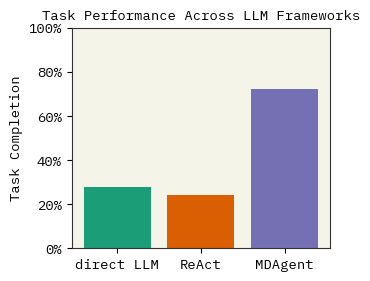

In [68]:
df.rename(index={"ReAct with Python REPL": "ReAct"}, inplace=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.bar(df.index, df['answer is logical '], color=colors)
plt.title('Task Performance Across LLM Frameworks', size=10)
plt.xlabel('')
plt.xticks(rotation=0)
plt.ylabel('Task Completion')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.tight_layout()
plt.savefig('compare-direct-llm-part1.png',dpi=300, bbox_inches='tight')

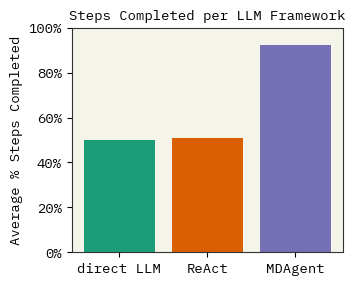

In [69]:
data = df['% step completed']

plt.bar(df.index, data, color=colors)
plt.title('Steps Completed per LLM Framework', size=10)
plt.xlabel('')
plt.xticks(rotation=0)
plt.ylabel('Average % Steps Completed')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.savefig('compare-direct-llm-part2.png',dpi=300, bbox_inches='tight')

### logical final answer vs N steps

In [70]:
# uses metric "answer is logical"

result = worksheet.get("D78:N81")
df = pd.DataFrame(result[1:], columns=result[0])
df.set_index(df.columns[0], inplace=True)
df = df.apply(pd.to_numeric)
df.head()

,1,2,3,4,5,6,7,8,9,10
,,,,,,,,,,
direct LLM,1.0,0.25,0.0,0.3333,0.5,0.0,0.0,0.0,0.5,0.0
ReAct with Python REPL,1.0,0.25,0.0,0.0000,0.0,0.0,0.5,0.5,0.0,0.0
MDAgent,1.0,1.00,1.0,0.3333,1.0,0.5,0.5,0.5,0.5,0.5


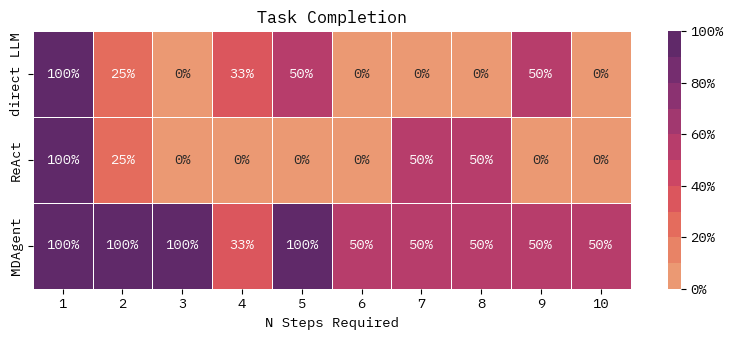

In [44]:
df.rename(index={"ReAct with Python REPL": "ReAct"}, inplace=True)

intervals = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
cmap = sns.color_palette("flare", len(intervals) - 1)

plt.figure(figsize=(8, 3.5))
sns.heatmap(df, vmin=0, annot=True, cmap=cmap, fmt=".0%", linewidths=0.5)

cbar = plt.gca().collections[0].colorbar
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

# # Set labels and title
plt.xlabel("N Steps Required")
plt.title("Task Completion")

# Show the plot
plt.tight_layout()
plt.savefig('compare-steps1.png',dpi=300)
plt.show()

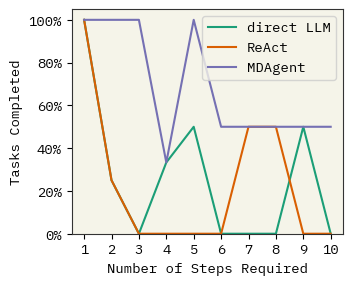

In [71]:
df.rename(index={"ReAct with Python REPL": "ReAct"}, inplace=True)

plt.plot(df.columns, df.loc['direct LLM'], label='direct LLM')
plt.plot(df.columns, df.loc['ReAct'], label='ReAct')
plt.plot(df.columns, df.loc['MDAgent'], label='MDAgent')
plt.legend()
plt.ylabel('Tasks Completed')
plt.xlabel('Number of Steps Required')
plt.ylim(0,1.05)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

### steps completed vs N steps

In [45]:
# uses metric "% steps completed"

result = worksheet.get("D72:N75")
df = pd.DataFrame(result[1:], columns=result[0])
df.set_index(df.columns[0], inplace=True)
df = df.apply(pd.to_numeric)
df.head()

,1,2,3,4,5,6,7,8,9,10
,,,,,,,,,,
direct LLM,1.0,0.625,0.4444,0.5000,0.7,0.2500,0.2857,0.1250,0.5556,0.15
ReAct with Python REPL,1.0,0.500,0.4444,0.1667,0.5,0.5833,0.6429,0.9375,0.0556,0.25
MDAgent,1.0,1.000,1.0000,0.8333,1.0,0.8333,0.7143,1.0000,0.9444,0.80


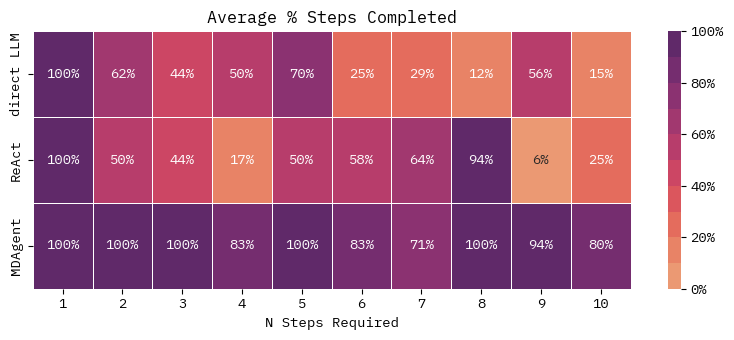

In [46]:
df.rename(index={"ReAct with Python REPL": "ReAct"}, inplace=True)

intervals = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
cmap = sns.color_palette("flare", len(intervals) - 1)

plt.figure(figsize=(8, 3.5))
sns.heatmap(df, vmin=0, annot=True, cmap=cmap, fmt=".0%", linewidths=0.5)

cbar = plt.gca().collections[0].colorbar
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

# # Set labels and title
plt.xlabel("N Steps Required")
plt.title("Average % Steps Completed")

# Show the plot
plt.tight_layout()
plt.savefig('compare-steps2.png',dpi=300)
plt.show()

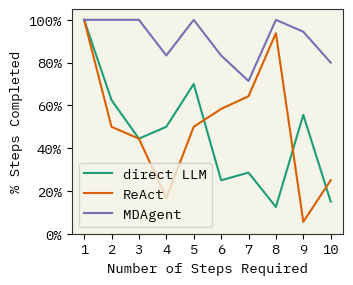

In [47]:
df.rename(index={"ReAct with Python REPL": "ReAct"}, inplace=True)

plt.plot(df.columns, df.loc['direct LLM'], label='direct LLM')
plt.plot(df.columns, df.loc['ReAct'], label='ReAct')
plt.plot(df.columns, df.loc['MDAgent'], label='MDAgent')
plt.legend()
plt.ylabel('% Steps Completed')
plt.xlabel('Number of Steps Required')
plt.ylim(0,1.05)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
